In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from IPython.display import clear_output
import seaborn as sns

import cPickle as pk
import pandas as pd
import networkx as nx
import scipy.sparse as sp
import itertools as itls
from itertools import combinations
import numpy as np
from math import sqrt

import sys

## Importing
[to top](#Table-of-Contents) 

In [3]:
pwd

u'/Users/innovation-sfi/Dropbox/Research/Innovation/EPO/Data_processing/Python'

In [4]:
df = pk.load(open('pickles_and_munged_csv/pre1950_cated_cumed_codes_as_ints_v1.pk', 'rb')); df.head()

appln_auth,AT,AU,BE,CA,CH,DE,DK,ES,FI,FR,...,IE,IS,IT,JP,LU,NL,NO,SE,SU,US
pub_year,,,,,,,,,,,,,,,,,,,,,
1836,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[1513, 1789], [1268, 1855], [1762, 1821], [24..."
1837,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[5834, 5836], [4907, 5440], [799, 5648], [602..."
1838,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[1537, 1774], [1154, 1208], [2724, 2748], [40..."
1839,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[4212, 4231], [5078, 6180], [4915, 5001], [33..."
1840,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[2722, 2748], [1862, 1862], [1161, 5985], [48..."


In [5]:
df.drop('SU', axis=1, inplace=True)

# AdjM building

In [6]:
def make_match_node_AdjDfs(df1, df2):
    
    # assumes dfs are symmetric and square
    # should implement a check here...
    
    # get union of dataframe indexes
    inx_1 = df1.index
    inx_2 = df2.index
    inx_un = inx_1.union(inx_2)
    
    # reindex both index and columns filling with 0
    df1 = df1.reindex(index=inx_un, fill_value=0).reindex(columns=inx_un, fill_value=0)
    df2 = df2.reindex(index=inx_un, fill_value=0).reindex(columns=inx_un, fill_value=0)
    
    return df1, df2

# DeltaCon

In [7]:
def compute_FBP_invs(A):

    # max power to calculate inverse to
    max_pw = 7

    # make identity
    I = sp.identity(A.shape[0])
 
    # remove self links - can't propogate beliefs to self - need to consider if the self links should be counted in
    # degree still?
    A = A - sp.dia_matrix((A.diagonal(), [0]),
                                    shape=(A.shape[0], A.shape[0]))

    # make degree matrix
    ds = [int(x) for x in A.sum(axis=1)]
    D = sp.dia_matrix((ds, [0]),
                     shape=(len(ds), len(ds)))
    
    # compute about-half homophility factor that gaurentees convergences of W power series
    c1 = D.sum() + 2
    c2 = np.dot(D,D).sum() - 1 
    h_h = sqrt((-c1+sqrt(c1**2 + 4*c2))
               /(8*c2)
              )
    
    # compute system constants ah (from ahD) and ch from (achA)
    ah = 4*(h_h**2) /(1-4*(h_h**2))
    ch = 2*h_h / (1-4*(h_h**2))
    
    # create matrix M to form (I - M)^-1
    M = ch*A - ah*D
    
    # expand to power series to compute inverse
    inv = I
    mat = M
    pwr = 1
    while mat.data[mat.data.argmax()] > 10**(-9) and pwr < max_pw:
        inv = inv + mat
        mat = mat * M
        pwr = pwr + 1
    return inv

In [8]:
def DeltaCon(A1, A2):
    
    # quick return for identical networks
    if (A1 != A2).nnz == 0:
        print 'Iden'
        return 1.0
    
    # initialize
    # prior belief for nodes (doesn't really affect results of deltacon - how not???)
    p = 0.51
    
    # Solve the linear BP systems (FaBP): inv corresponds to [I + ah*D - ch*A]^-1
    # and multiple by about-half prior beliefs
    inv1 = compute_FBP_invs(A1) * (p-0.5)
    inv2 = compute_FBP_invs(A2) * (p-0.5)
    
    # compute the similarities using Matusita distance
    diffM = (inv1.sqrt() - inv2.sqrt())
    diffM = diffM.multiply(diffM)
    
    # delete diagonal entries -  the influence nodes have on themselves
    diffM = diffM - sp.dia_matrix((diffM.diagonal(), [0]), shape=(diffM.shape[0], diffM.shape[0]))

    return 1 / (1 + sqrt(diffM.sum()))

# Applying

In [9]:
def compute_DeltaCon_sims(df, year):
    
    # create dataframe to store similarities
    df_temp = pd.DataFrame()
    
    # for countries in dataset
    for col1 in df:
        print '\n%s' % col1 # to see progress
        
        # if the country1 has no patents then set similarity to -1 to denote this
        if not df.loc[year,col1]:
            for col2 in df:
                df_temp.loc[col1,col2] = -1
                df_temp.loc[col2,col1] = -1
            
        # else create adjacency dataframe df1 (via nx.graph) for country1
        else:
            g1 = nx.MultiGraph()
            for ls in df.loc[year,col1]:
                g1.add_edges_from(combinations(ls, 2))
            Adf1 = nx.to_pandas_dataframe(g1)

            # for countries 'greater' than country1 in dataset 
            for col2 in df.loc[:, col1:]:
                
                # if countries are the same then set similarity to 1
                if col1 == col2:
                    print 'self',
                    df_temp.loc[col1,col2] = 1
                    
                # else if the country is not empty then calculate DeltaCon sim for country1 and country2
                elif df.loc[year,col2]:
                    print col2, # to see progress
                    
                    # create adjacency dataframe df2 (via nx.graph) for country2
                    g2 = nx.MultiGraph()
                    for ls in df.loc[year,col2]:
                        g2.add_edges_from(combinations(ls, 2))    
                    Adf2 = nx.to_pandas_dataframe(g2)
                    
                    # make adjacency dataframes compatible
                    Adf1, Adf2 = make_match_node_AdjDfs(Adf1, Adf2)
                    
                    # convert to csr and compute DeltaCon
                    sim = DeltaCon(sp.csr_matrix(Adf1.values), sp.csr_matrix(Adf2.values))
                    
                    #assign to dataframe
                    df_temp.loc[col1,col2] = sim
                    df_temp.loc[col2,col1] = sim
                    
    return df_temp

In [10]:
DelCon_test_2010 = compute_DeltaCon_sims(df,2010)


AT
self AU BE CA CH DE DK ES FI FR GB GR IE IS IT JP LU NL NO SE US 
AU
self BE CA CH DE DK ES FI FR GB GR IE IS IT JP LU NL NO SE US 
BE
self CA CH DE DK ES FI FR GB GR IE IS IT JP LU NL NO SE US 
CA
self CH DE DK ES FI FR GB GR IE IS IT JP LU NL NO SE US 
CH
self DE DK ES FI FR GB GR IE IS IT JP LU NL NO SE US 
DE
self DK ES FI FR GB GR IE IS IT JP LU NL NO SE US 
DK
self ES FI FR GB GR IE IS IT JP LU NL NO SE US 
ES
self FI FR GB GR IE IS IT JP LU NL NO SE US 
FI
self FR GB GR IE IS IT JP LU NL NO SE US 
FR
self GB GR IE IS IT JP LU NL NO SE US 
GB
self GR IE IS IT JP LU NL NO SE US 
GR
self IE IS IT JP LU NL NO SE US 
IE
self IS IT JP LU NL NO SE US 
IS
self IT JP LU NL NO SE US 
IT
self JP LU NL NO SE US 
JP
self LU NL NO SE US 
LU
self NL NO SE US 
NL
self NO SE US 
NO
self SE US 
SE
self US 
US
self


In [12]:
pk.dump(DelCon_test_2010, open('pickles_and_munged_csv/sim_dfs/all_grant_no_priors_pre1950_deltacon_union_sim_2010.pk','wb'))

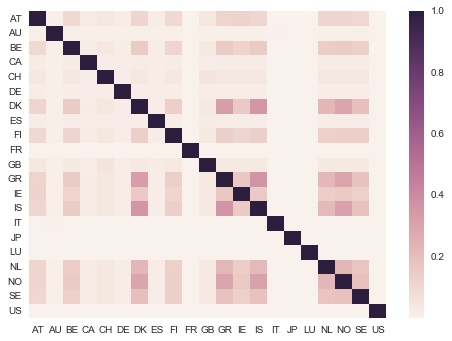

In [11]:
sns.heatmap(DelCon_test_2010)